In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm
import gdown
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
# Download and unzip the dataset
url = 'https://drive.google.com/uc?id=1lABUY5LjGAXwI_BEm2Uj35xOz5_ToO5y'
output = 'Dataset.zip'
gdown.download(url, output, quiet=False)
!unzip Dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1lABUY5LjGAXwI_BEm2Uj35xOz5_ToO5y
To: /content/Dataset.zip
100%|██████████| 197M/197M [00:01<00:00, 104MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: Preprocessed Dataset/val/altered_frames_cropped/r7B491zbxnw_0_pXJ6HOsm_iY_0.avi_frame_690.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/s8CuBT-MDYE_4_sZqIjquRfck_8.avi_frame_150.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/szxR2kMIWtI_0_saQyF1FPiqw_0.avi_frame_270.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/qpBoMZ8mAiQ_2_qpe2zydDOBM_0.avi_frame_210.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wTsoXbhr0N8_4_wnx2fsN9WP0_1.avi_frame_360.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wedLZCKQSrM_2_uvxJpaN72WQ_2.avi_frame_60.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/rBgM58w-gvM_1_pd8-LGKVGWQ_3.avi_frame_540.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/sZDvg03saDA_4_sZDvg03saDA_4.avi_frame_360.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wedLZCKQSrM_2_uvx

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of the model
    transforms.ToTensor(),
])

# Load datasets
train_dataset = ImageFolder(root='Preprocessed Dataset/train', transform=transform)
val_dataset = ImageFolder(root='Preprocessed Dataset/val', transform=transform)
test_dataset = ImageFolder(root='Preprocessed Dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def check_data_loader_dim(loader):
    # Checking the dataset
    for images, labels in loader:
        print('Image batch dimensions:', images.shape)
        print('Image label dimensions:', labels.shape)
        break

check_data_loader_dim(train_loader)
check_data_loader_dim(val_loader)
check_data_loader_dim(test_loader)

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])


In [ ]:
# class InceptionBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(InceptionBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
#         self.conv3 = nn.Conv2d(in_channels, out_channels[1], kernel_size=3, padding=1)
#         self.conv5 = nn.Conv2d(in_channels, out_channels[2], kernel_size=5, padding=2)
#         self.conv_dil = nn.Conv2d(in_channels, out_channels[3], kernel_size=3, padding=2, dilation=2)

#     def forward(self, x):
#         conv1 = F.relu(self.conv1(x))
#         conv3 = F.relu(self.conv3(x))
#         conv5 = F.relu(self.conv5(x))
#         conv_dil = F.relu(self.conv_dil(x))

#         return torch.cat([conv1, conv3, conv5, conv_dil], dim=1)


# class MesoInception4(nn.Module):
#     def __init__(self):
#         super(MesoInception4, self).__init__()

#         # Inception layer 1
#         self.inception_1 = InceptionBlock(3, [1, 4, 4, 2])

#         # Inception layer 2
#         self.inception_2 = InceptionBlock(11, [2, 4, 4, 2])

#         # Common layers
#         self.conv1 = nn.Conv2d(12, 16, kernel_size=5, padding=2)
#         self.relu = nn.ReLU(inplace=True)
#         self.bn = nn.BatchNorm2d(16)
#         self.max_pool1 = nn.MaxPool2d(kernel_size=2)
#         self.conv2 = nn.Conv2d(16, 16, kernel_size=5, padding=2)
#         self.max_pool2 = nn.MaxPool2d(kernel_size=4)
#         self.dropout = nn.Dropout2d(0.5)
#         self.fc1 = nn.Linear(12544, 16)
#         self.fc2 = nn.Linear(16, 1)
#         self.flatten = nn.Flatten()

#     def forward(self, x):
#         x = self.inception_1(x)
#         x = self.inception_2(x)

#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.bn(x)
#         x = self.max_pool1(x)

#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.bn(x)
#         x = self.max_pool2(x)

#         x = self.flatten(x)

#         x = self.dropout(x)
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x


In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels[1], kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels, out_channels[2], kernel_size=5, padding=2)
        self.conv_dil = nn.Conv2d(in_channels, out_channels[3], kernel_size=3, padding=2, dilation=2)

    def forward(self, x):
        conv1 = F.relu(self.conv1(x))
        conv3 = F.relu(self.conv3(x))
        conv5 = F.relu(self.conv5(x))
        conv_dil = F.relu(self.conv_dil(x))

        return torch.cat([conv1, conv3, conv5, conv_dil], dim=1)

class DeeperMesoInception4(nn.Module):
    def __init__(self):
        super(DeeperMesoInception4, self).__init__()

        # Inception layer 1
        self.inception_1 = InceptionBlock(3, [1, 4, 4, 2])

        # Inception layer 2
        self.inception_2 = InceptionBlock(11, [2, 4, 4, 2])

        # Common layers
        self.conv1 = nn.Conv2d(12, 16, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(16)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 28 * 28, 16)  # Adjusted input size
        self.fc2 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.inception_1(x)
        x = self.inception_2(x)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.max_pool1(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.max_pool3(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.max_pool4(x)

        x = self.flatten(x)

        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
# model = MesoInception4()
# Instantiate the model
model = DeeperMesoInception4()
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cpu'):
    model.to(device)
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Inside the training loop
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training", unit="batch"):
            inputs, labels = inputs.to(device), labels.unsqueeze(1).type(torch.float).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Reshape the target tensor to match the output size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.0).float()
            running_corrects += torch.sum(preds == labels.data)

        # Calculate epoch-wise training loss and accuracy
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation Phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation", unit="batch"):
                inputs, labels = inputs.to(device), labels.unsqueeze(1).type(torch.float).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())

                # Update running loss and correct predictions
                running_loss += loss.item() * inputs.size(0)
                preds = (outputs > 0.0).float()
                running_corrects += torch.sum(preds == labels.data)

        # Calculate epoch-wise validation loss and accuracy
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print epoch-wise training and validation metrics
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    return model, (train_losses, train_accuracies, val_losses, val_accuracies)


In [ ]:
# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
trained_model, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device=device)

# Plot training metrics
train_accuracy = [accuracy.cpu().item() for accuracy in metrics[1]]
val_accuracy = [accuracy.cpu().item() for accuracy in metrics[3]]


Epoch 1/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 1/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 1/25
Train Loss: 0.6947 Acc: 0.5033
Validation Loss: 0.6935 Acc: 0.4999


Epoch 2/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 2/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 2/25
Train Loss: 0.6933 Acc: 0.4973
Validation Loss: 0.6931 Acc: 0.5003


Epoch 3/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 3/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3/25
Train Loss: 0.6933 Acc: 0.4955
Validation Loss: 0.6932 Acc: 0.5001


Epoch 4/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 4/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4/25
Train Loss: 0.6932 Acc: 0.5039
Validation Loss: 0.6932 Acc: 0.4999


Epoch 5/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 5/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5/25
Train Loss: 0.6936 Acc: 0.5045
Validation Loss: 0.6932 Acc: 0.4999


Epoch 6/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 6/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6/25
Train Loss: 0.6932 Acc: 0.4973
Validation Loss: 0.6931 Acc: 0.5001


Epoch 7/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 7/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7/25
Train Loss: 0.6932 Acc: 0.5017
Validation Loss: 0.6932 Acc: 0.4999


Epoch 8/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 8/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8/25
Train Loss: 0.6933 Acc: 0.5013
Validation Loss: 0.6932 Acc: 0.5001


Epoch 9/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 9/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9/25
Train Loss: 0.6932 Acc: 0.4998
Validation Loss: 0.6932 Acc: 0.5001


Epoch 10/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 10/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10/25
Train Loss: 0.6932 Acc: 0.5016
Validation Loss: 0.6932 Acc: 0.4999


Epoch 11/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 11/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 11/25
Train Loss: 0.6932 Acc: 0.4956
Validation Loss: 0.6931 Acc: 0.5001


Epoch 12/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 12/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12/25
Train Loss: 0.6932 Acc: 0.4911
Validation Loss: 0.6931 Acc: 0.5001


Epoch 13/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 13/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13/25
Train Loss: 0.6932 Acc: 0.5006
Validation Loss: 0.6932 Acc: 0.4999


Epoch 14/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 14/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14/25
Train Loss: 0.6932 Acc: 0.4948
Validation Loss: 0.6931 Acc: 0.4999


Epoch 15/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 15/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15/25
Train Loss: 0.6932 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 16/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 16/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16/25
Train Loss: 0.6932 Acc: 0.4950
Validation Loss: 0.6932 Acc: 0.5001


Epoch 17/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 17/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17/25
Train Loss: 0.6932 Acc: 0.5031
Validation Loss: 0.6932 Acc: 0.5001


Epoch 18/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 18/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18/25
Train Loss: 0.6932 Acc: 0.4950
Validation Loss: 0.6931 Acc: 0.5001


Epoch 19/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 19/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19/25
Train Loss: 0.6932 Acc: 0.4975
Validation Loss: 0.6931 Acc: 0.5001


Epoch 20/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 20/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20/25
Train Loss: 0.6932 Acc: 0.4995
Validation Loss: 0.6932 Acc: 0.5001


Epoch 21/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 21/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 21/25
Train Loss: 0.6932 Acc: 0.5007
Validation Loss: 0.6932 Acc: 0.4999


Epoch 22/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 22/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22/25
Train Loss: 0.6932 Acc: 0.4997
Validation Loss: 0.6932 Acc: 0.5001


Epoch 23/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 23/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23/25
Train Loss: 0.6932 Acc: 0.5014
Validation Loss: 0.6932 Acc: 0.4999


Epoch 24/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 24/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24/25
Train Loss: 0.6932 Acc: 0.4965
Validation Loss: 0.6932 Acc: 0.4999


Epoch 25/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 25/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25/25
Train Loss: 0.6932 Acc: 0.4977
Validation Loss: 0.6932 Acc: 0.4999


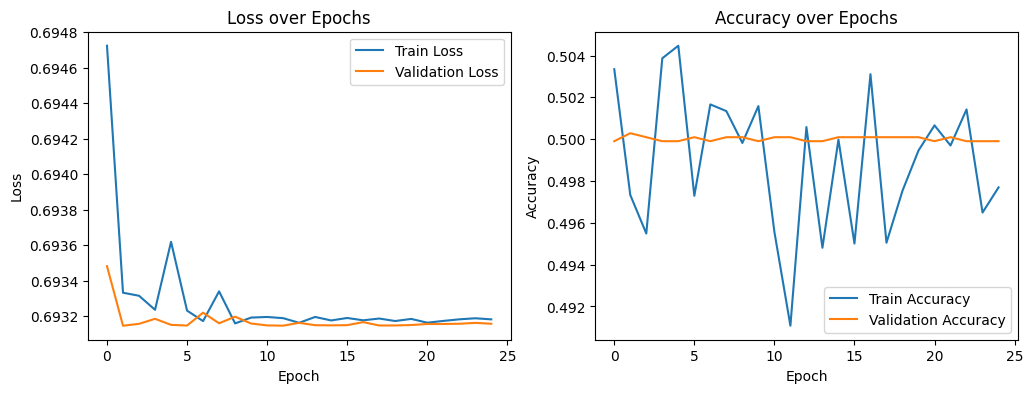

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(metrics[0], label='Train Loss')
plt.plot(metrics[2], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 1, 224, 224]               4
            Conv2d-2          [-1, 4, 224, 224]             112
            Conv2d-3          [-1, 4, 224, 224]             304
            Conv2d-4          [-1, 2, 224, 224]              56
    InceptionBlock-5         [-1, 11, 224, 224]               0
            Conv2d-6          [-1, 2, 224, 224]              24
            Conv2d-7          [-1, 4, 224, 224]             400
            Conv2d-8          [-1, 4, 224, 224]           1,104
            Conv2d-9          [-1, 2, 224, 224]             200
   InceptionBlock-10         [-1, 12, 224, 224]               0
           Conv2d-11         [-1, 16, 224, 224]           4,816
             ReLU-12         [-1, 16, 224, 224]               0
      BatchNorm2d-13         [-1, 16, 224, 224]              32
        MaxPool2d-14         [-1, 16, 1

In [ ]:
torch.save(trained_model, 'MesoInception_model.pth')

In [ ]:
class_names = train_dataset.classes

In [ ]:
# Load the entire model
trained_model = torch.load('MesoInception_model.pth')

# Set to evaluation mode for inference
trained_model.eval()

# Move model to the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)


DeeperMesoInception4(
  (inception_1): InceptionBlock(
    (conv1): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv_dil): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  )
  (inception_2): InceptionBlock(
    (conv1): Conv2d(11, 2, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2d(11, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(11, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv_dil): Conv2d(11, 2, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  )
  (conv1): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [ ]:
trained_model.eval()

test_loss = 0
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for data, target in test_loader:
        # Moving data to the same device as model
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = trained_model(data)

        # Compute the loss
        test_loss += criterion(output, target.view(-1, 1).float()).item()

        # Convert output probabilities to predicted class
        preds = output > 0.0

        # Count correct predictions
        correct += torch.sum(preds == target.view(-1, 1).data).item()
        total += target.size(0)

# Calculate average loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.0217, Test Accuracy: 0.5000


In [ ]:
trained_model.eval()

# Lists to store actual and predicted labels
actuals = []
predictions = []

# Iterate over the test_loader
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Get predictions from the model
    with torch.no_grad():
        outputs = trained_model(images)

    # Apply sigmoid and round to get the binary class
    predicted_labels = torch.round(torch.sigmoid(outputs)).squeeze()

    # Store the true and predicted labels
    actuals.extend(labels.cpu().numpy())
    predictions.extend(predicted_labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)

# Calculate precision, recall, f1-score, and support
precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')

# Calculate accuracy
accuracy = accuracy_score(actuals, predictions)

# Calculate AUC-ROC
auc_roc = roc_auc_score(actuals, predictions)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)

print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC:", auc_roc)


Confusion Matrix:
[[   0 2697]
 [   0 2697]]

Accuracy: 50.00%
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666
AUC-ROC: 0.5
